# Stacking Ensemble

**base learner：**
- GBR、lightGBM、XGBoost、RandomForest、ExtraRandomTrees、SVR

**meta learner：**
- XGBoost

**Introduce the six most important features：**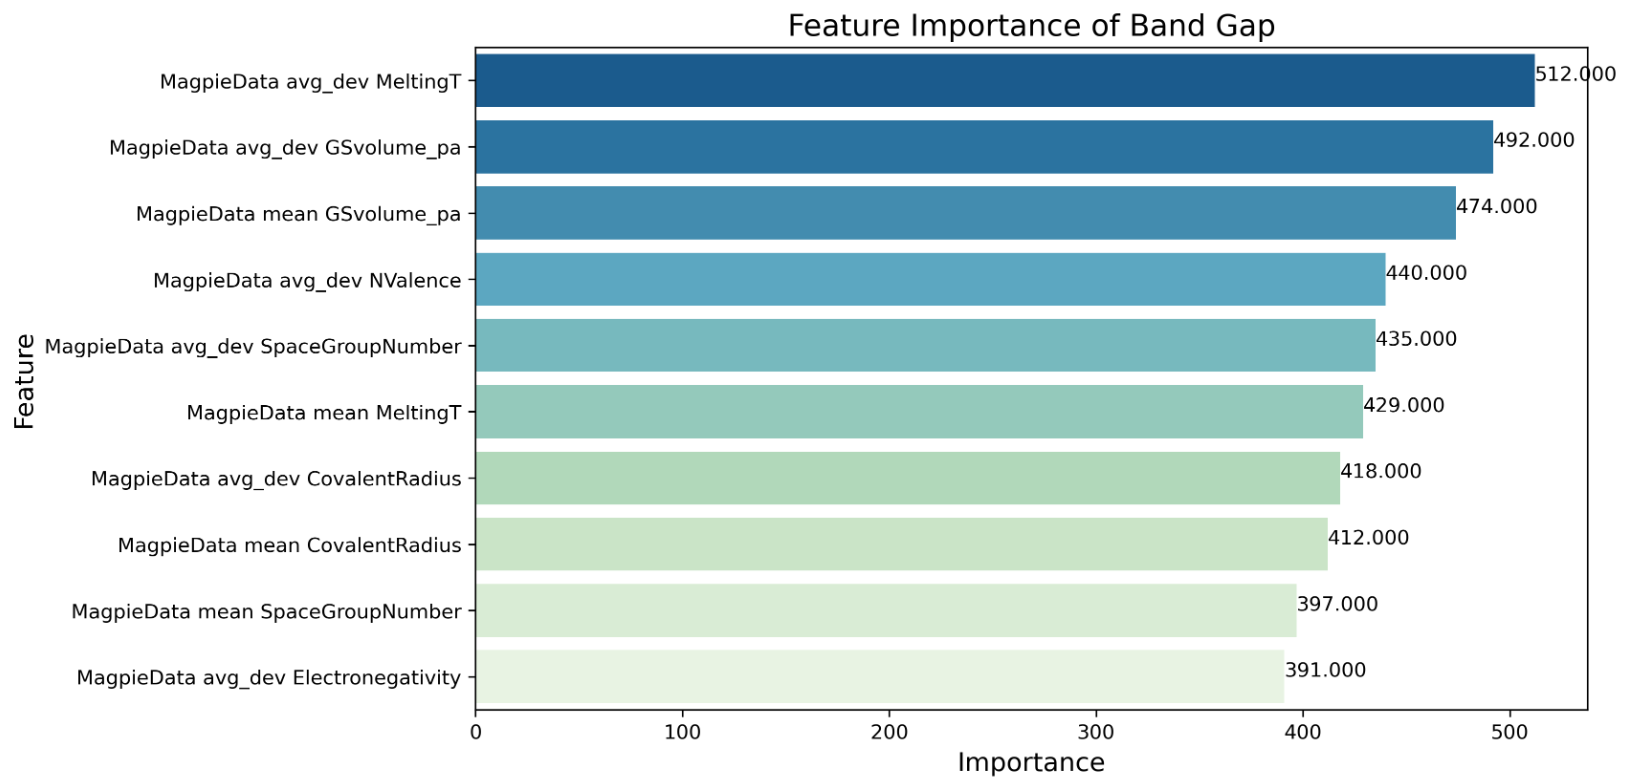

In [1]:
import os
import sys
import pandas as pd
import numpy as np
np.random.seed(42)
current_path = os.getcwd()
current_path

'/workspaces/Bg_pre2'

In [2]:
# Set random seed for reproducibility
RANDOM_SEED = 42
# 
FIG_SHOW = False

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_test_set.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'exp_test_set.csv'))
# mix test data
mix_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mix_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

mix_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mix_test_set.csv'))
mixed_test_X = mix_test.drop(columns=['composition', 'band_gap'])
mixed_test_y = mix_test['band_gap']

In [5]:
dft_train_X.shape, exp_train_X.shape, mixed_test_X.shape, mixed_test_y.shape

((8268, 132), (2544, 132), (1172, 132), (1172,))

## Base Learners Train

In [6]:
from sklearn.base import clone
# Import sklearn models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

In [7]:
# define dft_models with the best hyper parameters in the pervious step
dft_models = {
    # GBDT models
    'GBR': GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=10, 
    max_features=0.25, subsample=1.0, random_state=RANDOM_SEED),

    'LightGBM': LGBMRegressor(learning_rate=0.2, max_depth=-1, n_estimators=500,
    subsample=0.7, colsample_bytree=1.0,
    objective='regression', random_state=RANDOM_SEED, n_jobs=-1),

    'XGBoost': XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1),

    # Random Forest models
    'RandomForest': RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1),
    
    'ExtraRandomTrees': ExtraTreesRegressor(
    n_estimators=500, max_depth=None, min_samples_split=7, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1),
    
    'SVR': SVR(kernel='rbf', C=25, epsilon=0.07, gamma=0.01)
}

In [8]:
meta_train_X = pd.DataFrame()
meta_train_y = exp_train_y
dft_trained_models = {}
model_number = 0
model_nums = len(dft_models)

# train dft models and add the predictions to the exp train set
for model_name, model in dft_models.items():
    model_number += 1
    print(f"[{model_number}/{model_nums} - {model_name}] Training...")
    # train the model
    dft_model = SingleModel(clone(model), random_state=RANDOM_SEED)
    dft_model.train(dft_train_X, dft_train_y)
    y_pred = dft_model.predict(exp_train_X)
    meta_train_X[model_name] = y_pred
    # save the model
    dft_trained_models[model_name] = dft_model

[1/6 - GBR] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=  50.1s
Model training completed!
[2/6 - LightGBM] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13971
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 125
[LightGBM] [Info] Start training from score 1.459738
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.8s
Model training completed!
[3/6 - XGBoost] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............. (step 2 of 2) Processing model, total=   4.1s
Model training completed!
[4/6 - RandomForest] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  19.2s
Model training completed!
[5/6 - ExtraRandomTrees] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  10.0s
Model training completed!
[6/6 - SVR] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   9.8s
Model training completed!


In [9]:
meta_train_X.head()

,GBR,LightGBM,XGBoost,RandomForest,ExtraRandomTrees,SVR
0,0.598977,0.811045,0.779588,0.720591,0.680390,0.490250
1,0.449239,0.466805,0.342849,0.414981,0.416518,1.298178
2,0.274279,0.205616,0.214497,0.516591,0.428156,0.121944
3,0.212072,0.415687,0.232812,0.368164,0.339918,0.299264
4,1.604925,1.546316,1.492730,1.556778,1.580059,1.346978


In [10]:
# whether to use important features of exp as meta features
USE_IMPORTANT_FEAT = True
important_features = ['MagpieData avg_dev MeltingT', 'MagpieData avg_dev GSvolume_pa', 'MagpieData mean GSvolume_pa',
                      'MagpieData avg_dev NValence', 'MagpieData avg_dev SpaceGroupNumber', 'MagpieData mean MeltingT']


if USE_IMPORTANT_FEAT:
    important_features_train_df = exp_train_X[important_features].copy()
    meta_train_X = pd.concat([important_features_train_df, meta_train_X], axis=1)

    # add the important features to the test set
    meta_dft_test_X = dft_test_X[important_features].copy()
    meta_exp_test_X = exp_test_X[important_features].copy()
    meta_mix_test_X = mixed_test_X[important_features].copy()   
else:
    meta_dft_test_X = pd.DataFrame()
    meta_exp_test_X = pd.DataFrame()
    meta_mix_test_X = pd.DataFrame()


In [11]:
# add dft model predictions to the test set
for model_name, model in dft_trained_models.items():
    print(f"[{model_name}] Predicting...")
    # predict the test set
    y_pred = model.predict(dft_test_X)
    meta_dft_test_X[model_name] = y_pred
    # predict the mixed test set
    y_pred = model.predict(mixed_test_X)
    meta_mix_test_X[model_name] = y_pred
    # predict the exp test set
    y_pred = model.predict(exp_test_X)
    meta_exp_test_X[model_name] = y_pred

[GBR] Predicting...
[LightGBM] Predicting...
[XGBoost] Predicting...
[RandomForest] Predicting...


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[ExtraRandomTrees] Predicting...
[SVR] Predicting...


####################################################################################################
Training Stacking XGBoost on train data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s
Model training completed!
[Train_error] Evaluating Stacking XGBoost on train set:


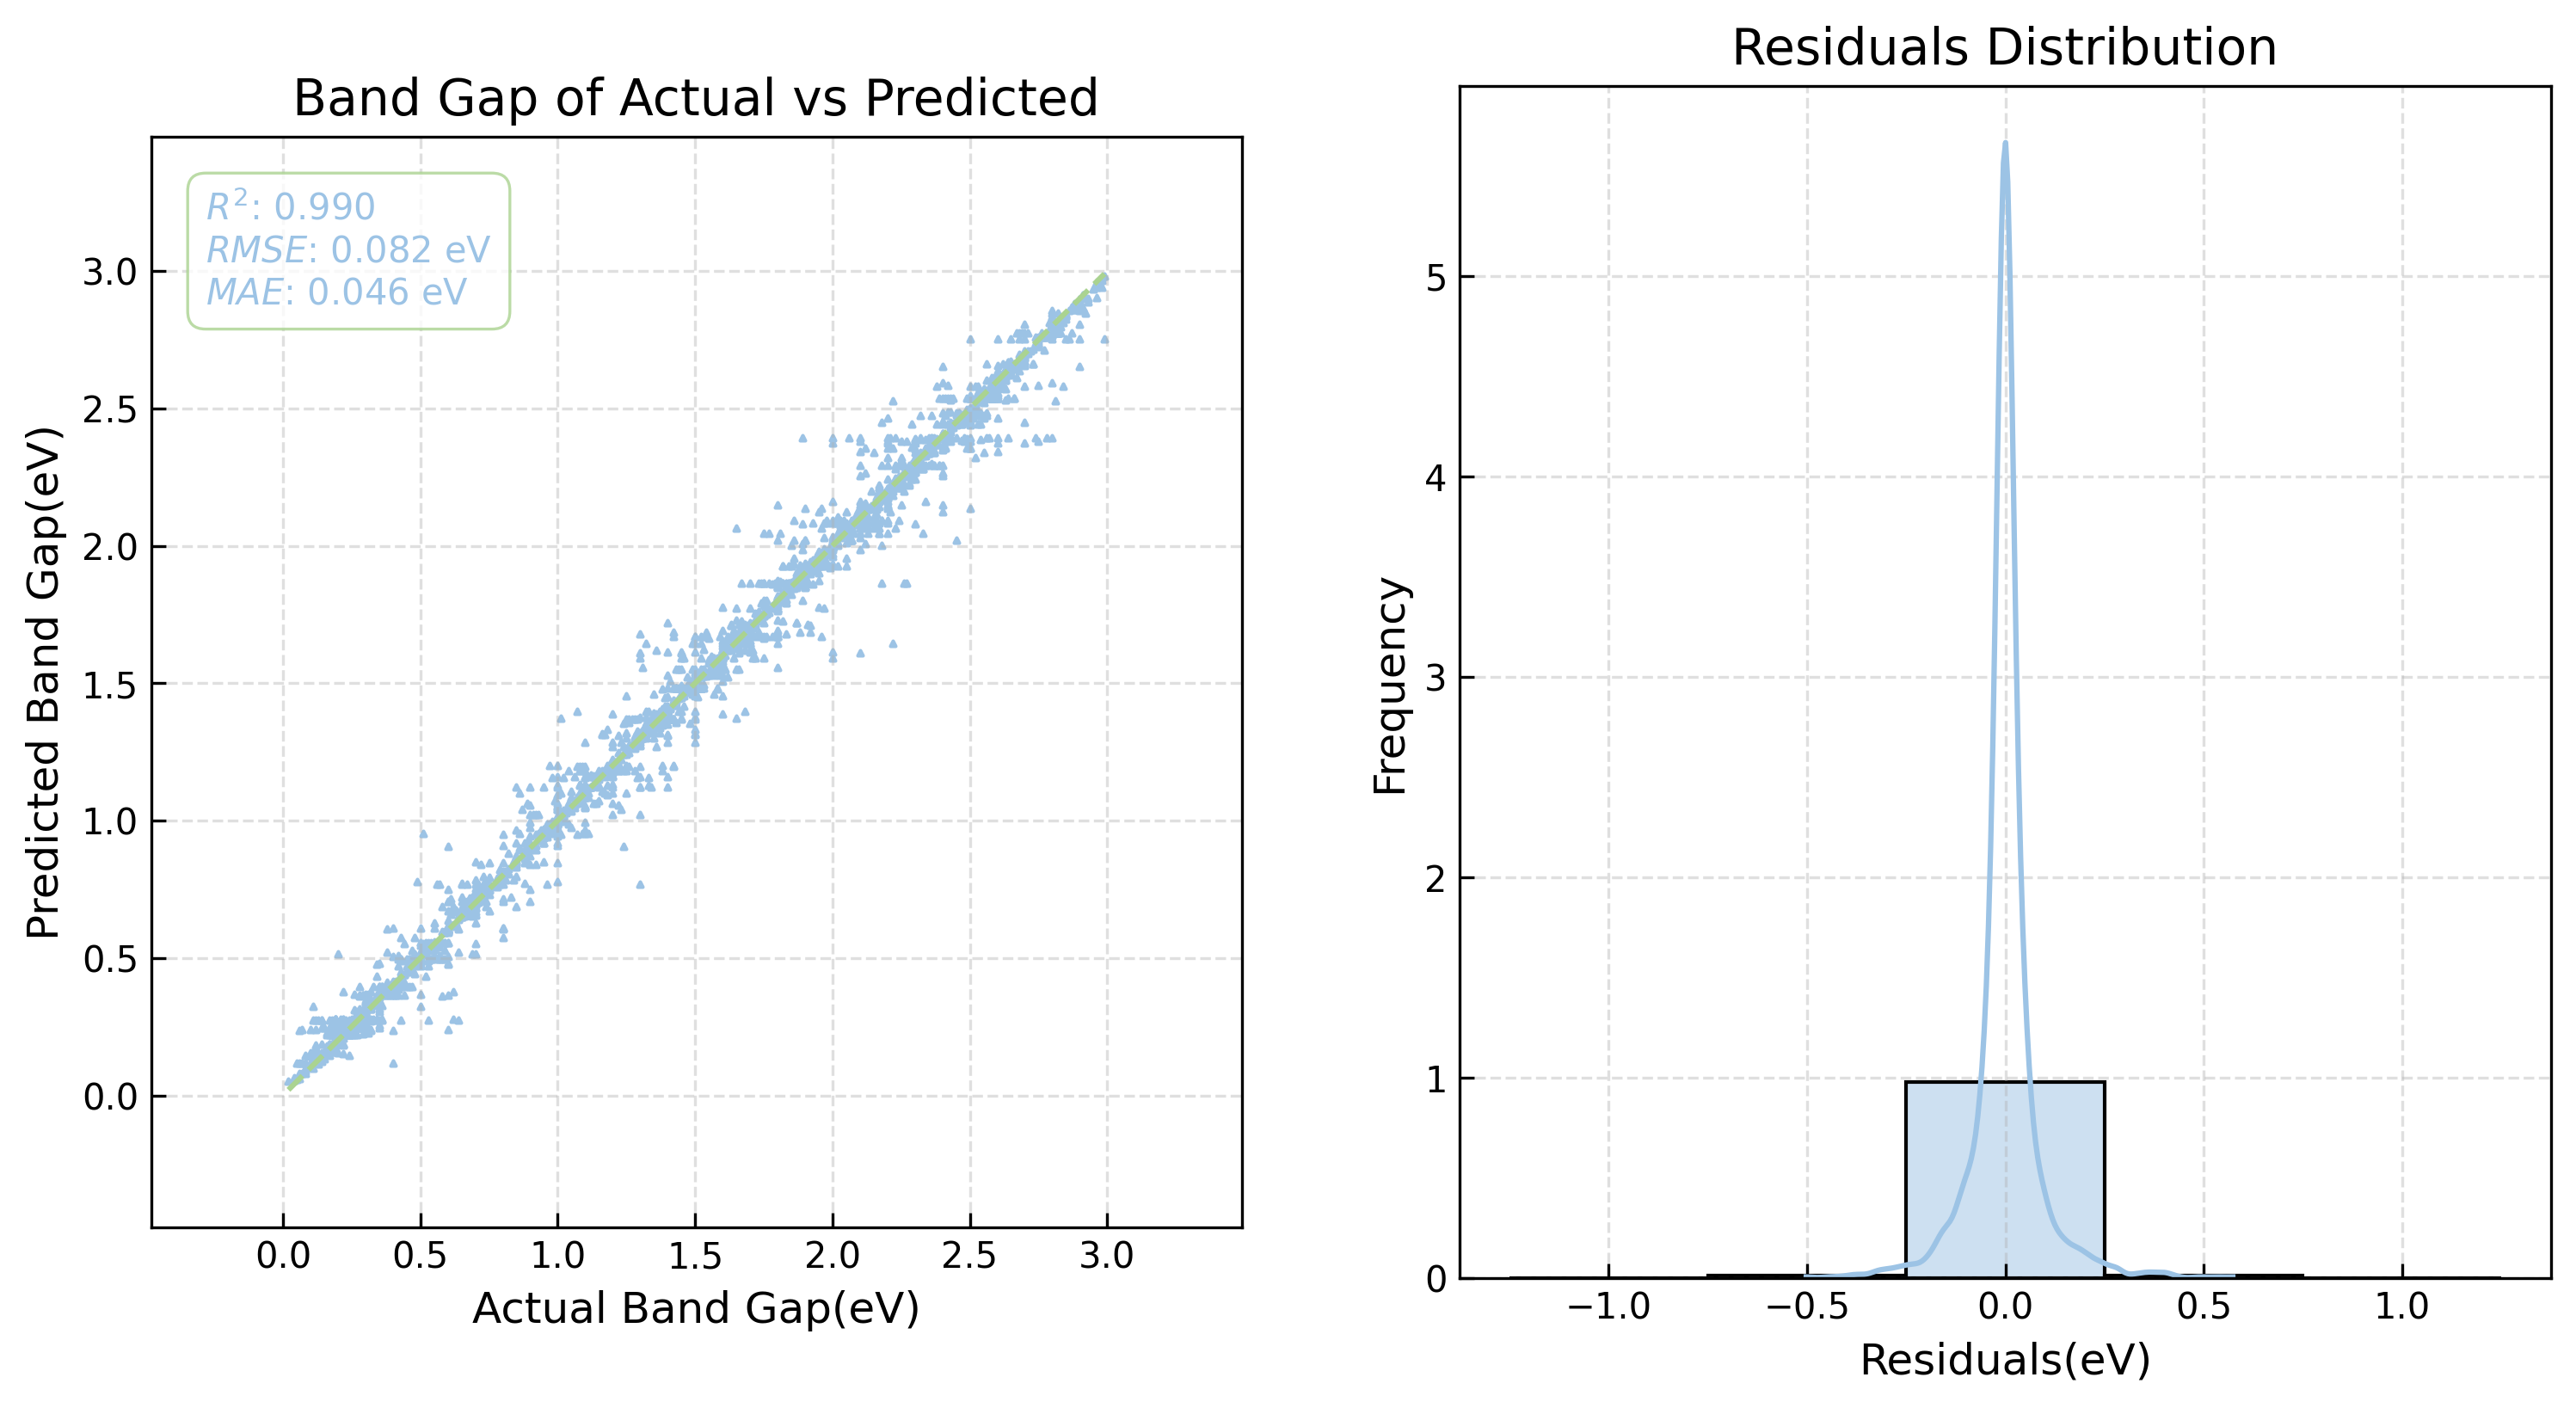


Model Evaluation Results:
Test set size: 2544
Test set: R²: 0.9897 RMSE: 0.0815 MAE: 0.0461 MAPE: 5.7164%
[Test Meta -> DFT] Evaluating Stacking XGBoost on DFT test set:


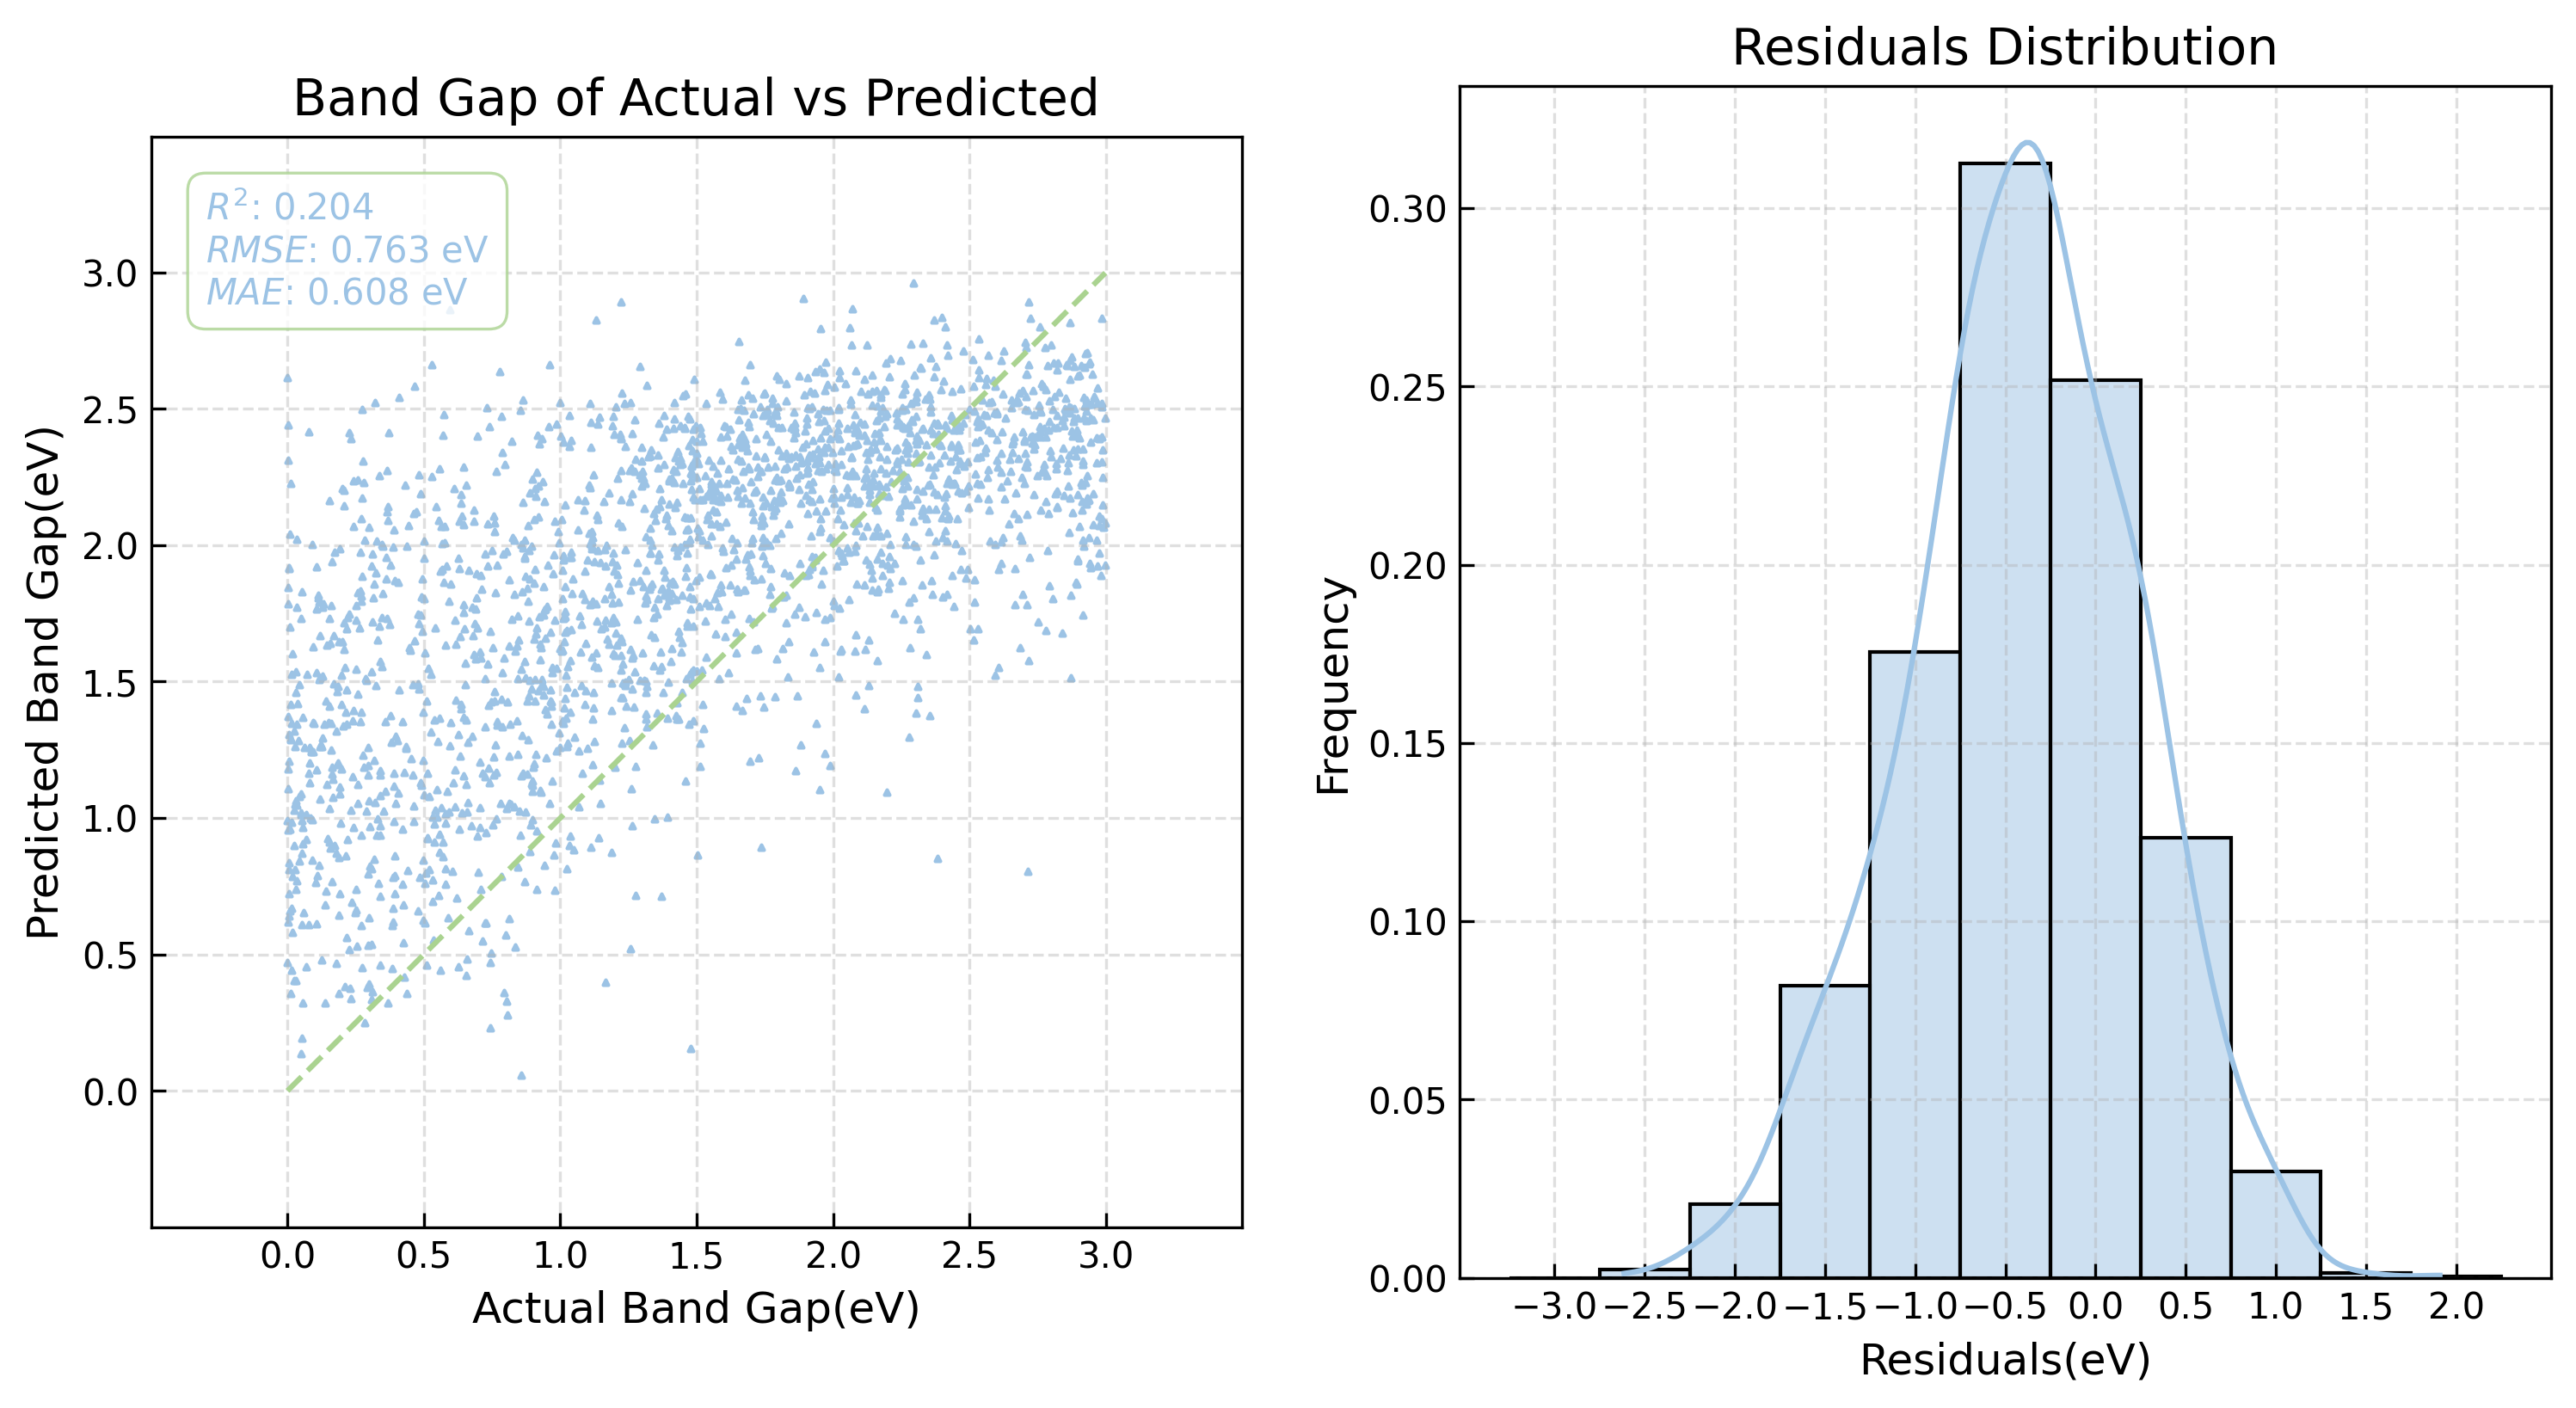


Model Evaluation Results:
Test set size: 2074
Test set: R²: 0.2038 RMSE: 0.7632 MAE: 0.6081 MAPE: 1558.0551%
[Test Meta -> EXP] Evaluating Stacking XGBoost on EXP test set:


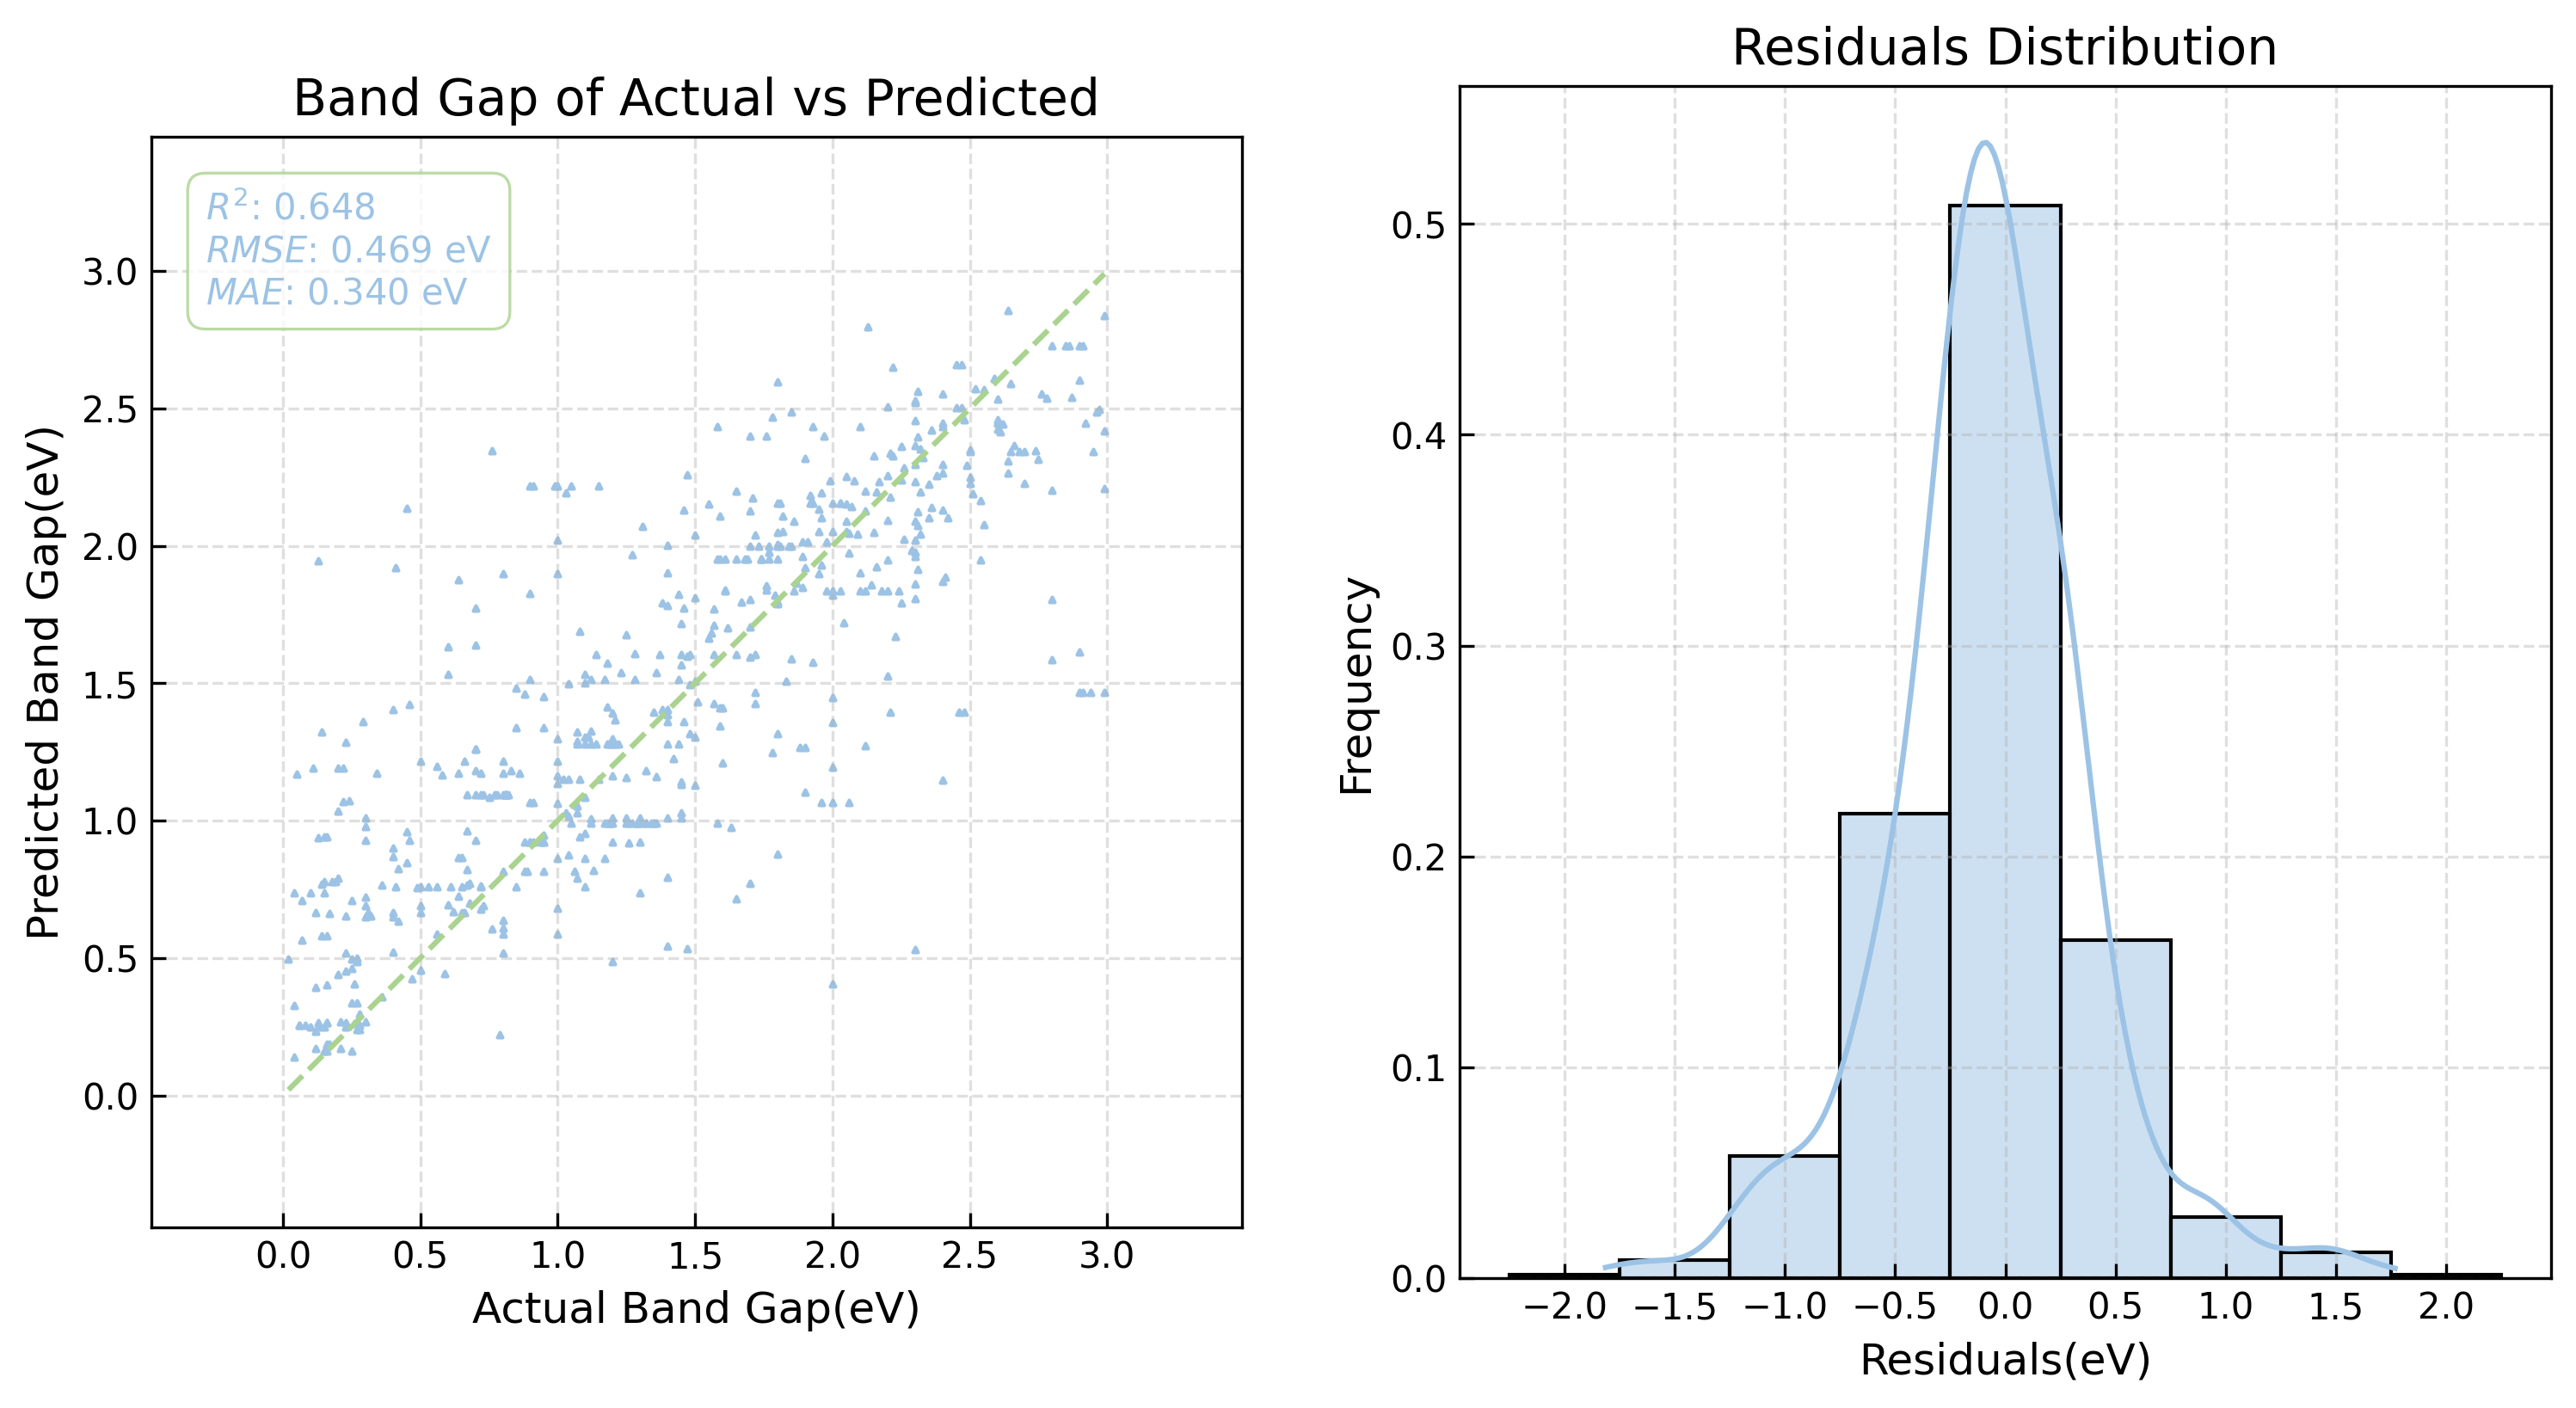


Model Evaluation Results:
Test set size: 586
Test set: R²: 0.6483 RMSE: 0.4693 MAE: 0.3400 MAPE: 67.8869%
[Test Meta -> MIX] Evaluating Stacking XGBoost on mixed test set:


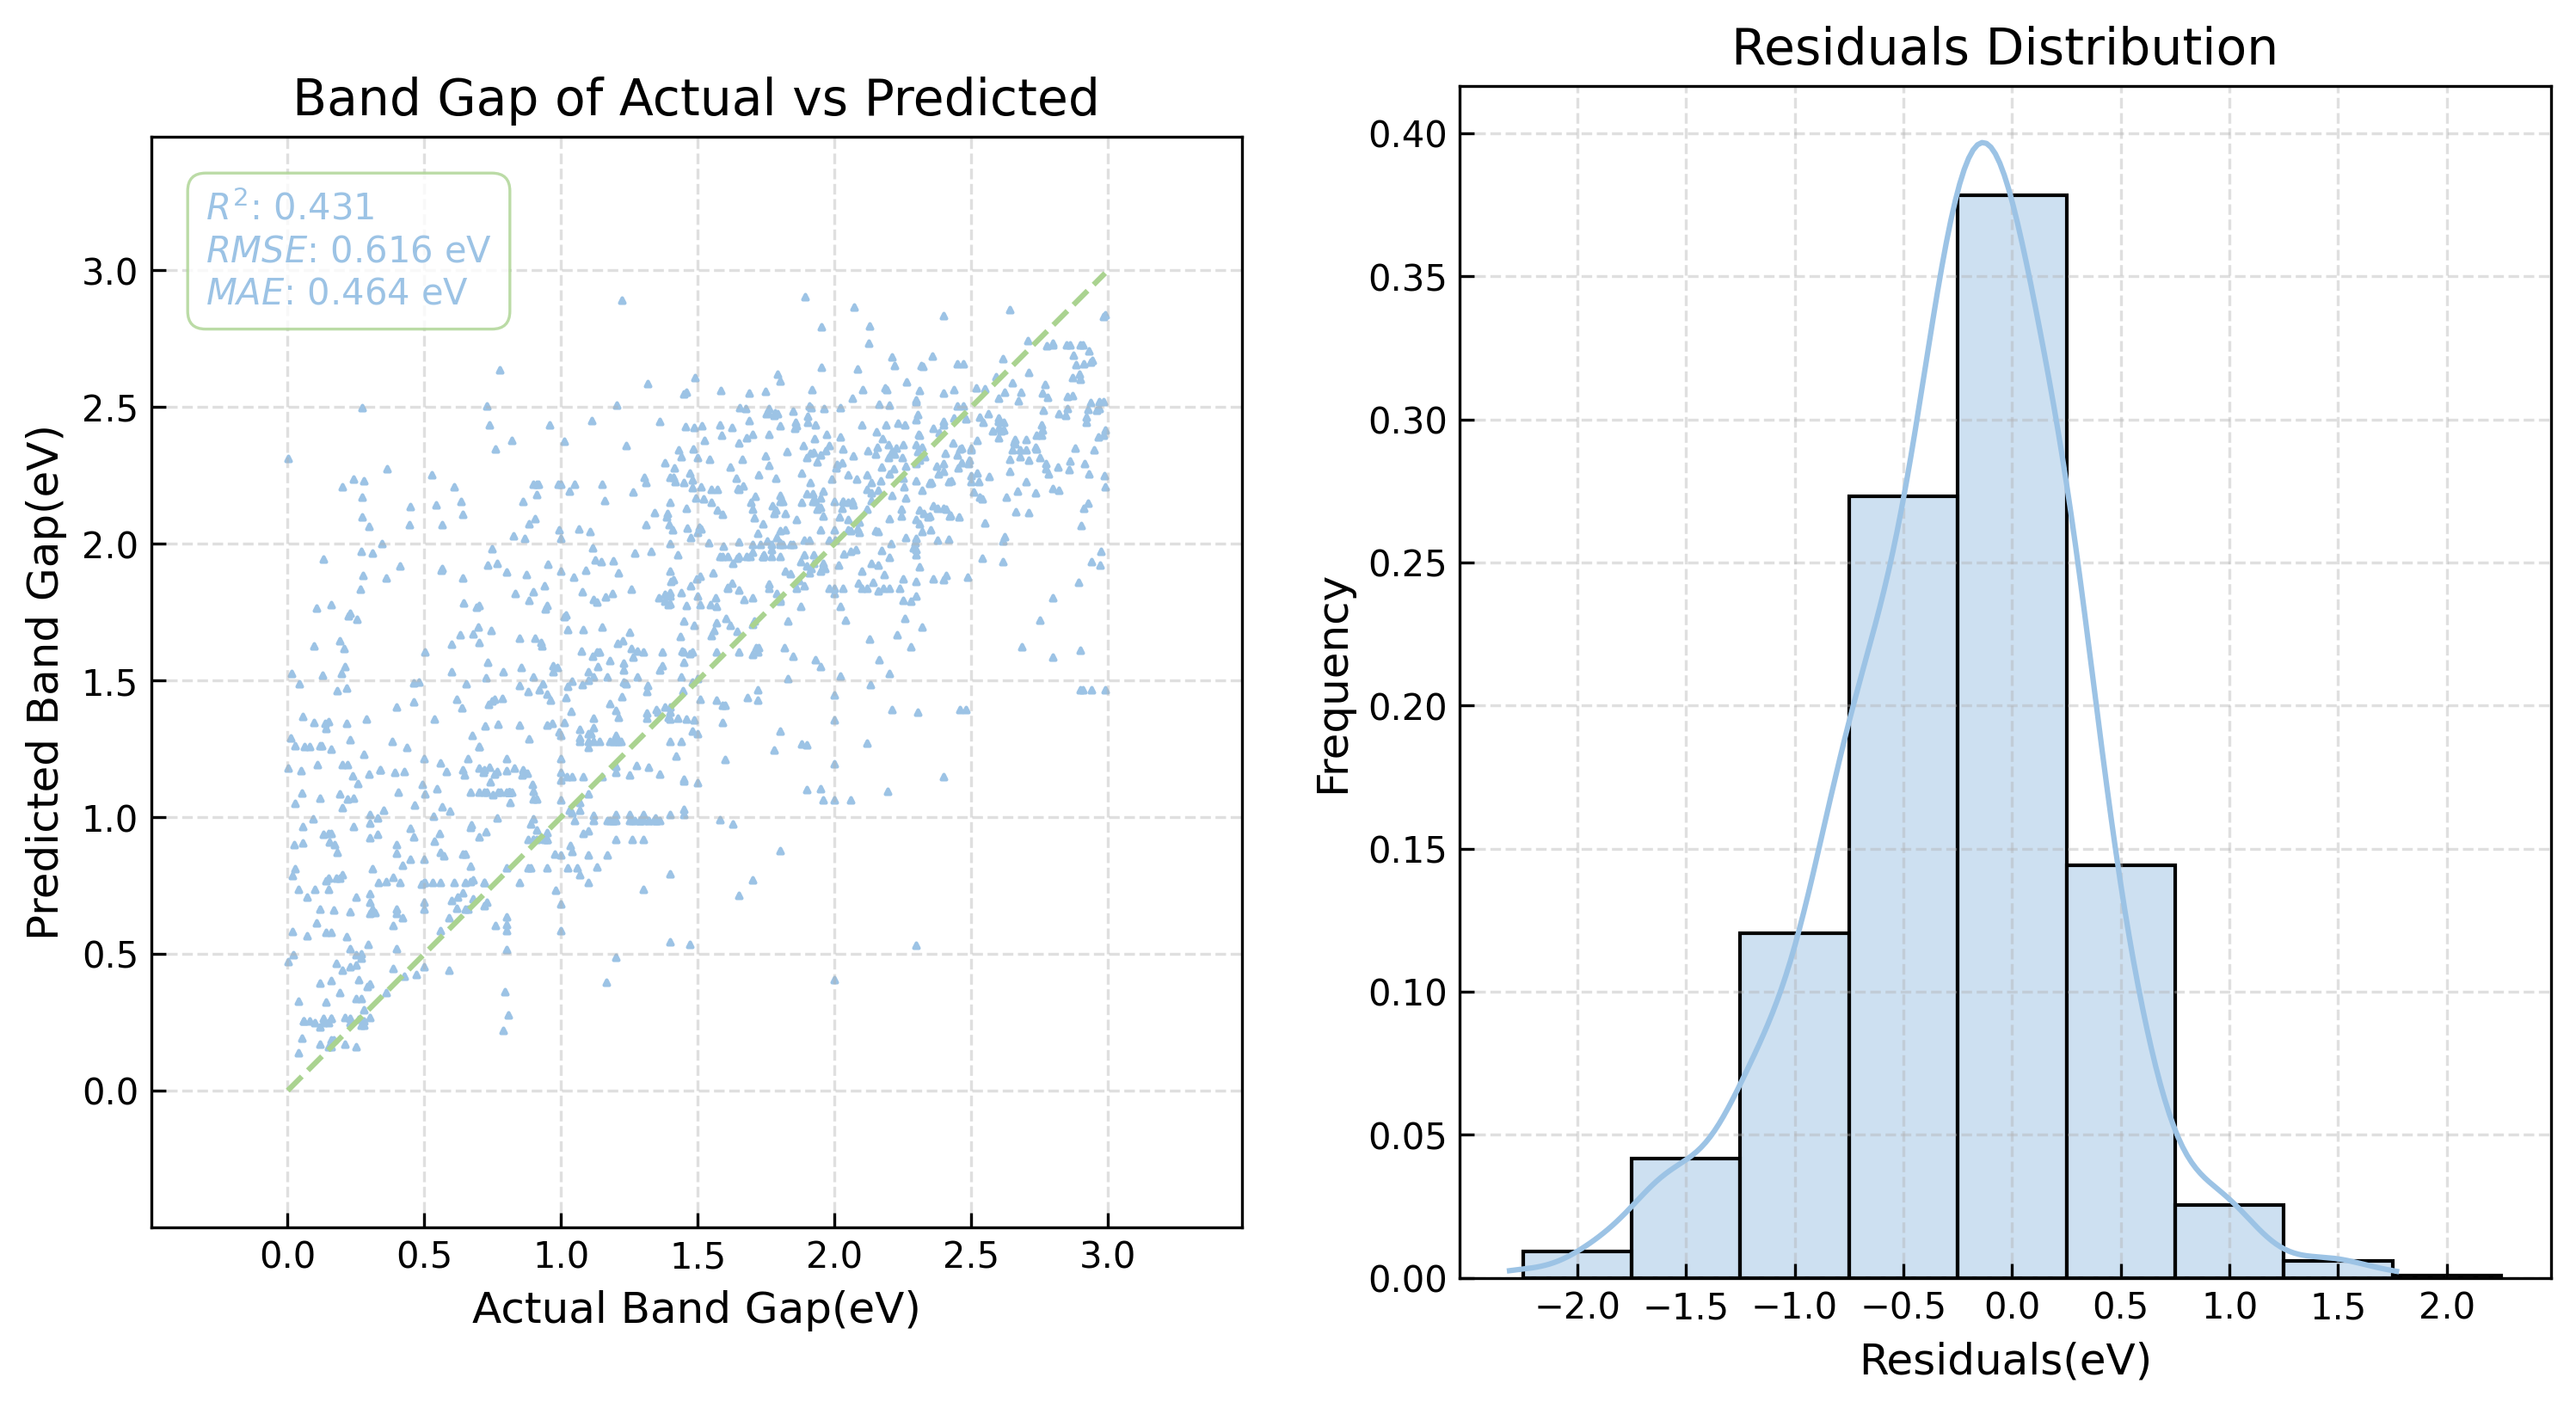


Model Evaluation Results:
Test set size: 1172
Test set: R²: 0.4308 RMSE: 0.6163 MAE: 0.4644 MAPE: 338.4831%


,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Stacking XGBoost,Train,meta,meta,0.989727,0.081504,0.046143
1,Stacking XGBoost,Test,meta,dft,0.203850,0.763164,0.608136
2,Stacking XGBoost,Test,meta,exp,0.648289,0.469285,0.340041
3,Stacking XGBoost,Test,meta,mix,0.430830,0.616264,0.464387


In [12]:
# meta model training
# 
MODEL_NAME = 'Stacking XGBoost'
# Train the model with the best hyperparameters on the entire training set
xgboost = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=0.9,
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on mixed data
print("#" * 100)
print(f"Training {MODEL_NAME} on train data:")
print("-" * 100)

model = SingleModel(xgboost, random_state=RANDOM_SEED)
model.train(meta_train_X, meta_train_y)

# evaluate on the train set
print(f"[Train_error] Evaluating {MODEL_NAME} on train set:")
metrics = model.evaluate(meta_train_X, meta_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'meta',
'Test_set': 'meta',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test Meta -> DFT] Evaluating {MODEL_NAME} on DFT test set:")
metrics = model.evaluate(meta_dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test Meta -> EXP] Evaluating {MODEL_NAME} on EXP test set:")
metrics = model.evaluate(meta_exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the mixed test set
print(f"[Test Meta -> MIX] Evaluating {MODEL_NAME} on mixed test set:")
metrics = model.evaluate(meta_mix_test_X, mixed_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,    
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# save the model metrics to a csv file
model_metrics.to_csv(os.path.join('./metrics', 'stacking_metrics.csv'), index=False)
model_metrics